# Face Expression Recognition Project

In [1]:
# notebook imports

import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split

import keras 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, BatchNormalization, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator , img_to_array, load_img


In [2]:
# get helper functions

!wget https://raw.githubusercontent.com/benjaminogbonna/helper_codes/main/helper_functions.py

from helper_functions import unzip_data

--2022-03-07 08:27:57--  https://raw.githubusercontent.com/benjaminogbonna/helper_codes/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10642 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.39K  --.-KB/s    in 0s      

2022-03-07 08:27:57 (91.1 MB/s) - ‘helper_functions.py’ saved [10642/10642]



In [5]:
# get data

face_data2 = '/content/drive/MyDrive/Colab Notebooks/Face_expression_recognition_project/face_expression/face_expression.zip'
unzip_data(face_data2)

train_dir = 'face_expression/train'
validation_dir = 'face_expression/validation'

# train_dir = 'data/face_expression/train'
# validation_dir = 'data/face_expression/validation'

# Train model




In [ ]:
TARGET_SIZE = (48, 48)
BATCH_SIZE = 32


train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range=.2,
                                   zoom_range=.2,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   rotation_range = 20,
                                   horizontal_flip = True)

validation_datagen = ImageDataGenerator(rescale= 1.0/255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=TARGET_SIZE,
                                                    color_mode="grayscale",
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    shuffle=True)

validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                    target_size=TARGET_SIZE,
                                                    color_mode="grayscale",
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [ ]:
# second model: improved
num_classes = 7 

model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(num_classes, activation='softmax'))


model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(lr=.0001),
                metrics=['accuracy']
                )

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
epochs = 20
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.n//train_generator.batch_size,
                    epochs=epochs,
                    validation_data = validation_generator,
                    validation_steps = validation_generator.n//validation_generator.batch_size,
                    )

Epoch 1/20
900/900 [==============================] - 58s 52ms/step - loss: 2.0007 - accuracy: 0.2230 - val_loss: 1.7701 - val_accuracy: 0.2648
Epoch 2/20
900/900 [==============================] - 43s 48ms/step - loss: 1.8948 - accuracy: 0.2395 - val_loss: 1.8097 - val_accuracy: 0.2911
Epoch 3/20
900/900 [==============================] - 43s 48ms/step - loss: 1.8178 - accuracy: 0.2767 - val_loss: 1.8024 - val_accuracy: 0.3168
Epoch 4/20
900/900 [==============================] - 42s 47ms/step - loss: 1.7581 - accuracy: 0.3076 - val_loss: 1.6014 - val_accuracy: 0.3915
Epoch 5/20
900/900 [==============================] - 42s 47ms/step - loss: 1.6950 - accuracy: 0.3351 - val_loss: 1.5562 - val_accuracy: 0.4107
Epoch 6/20
900/900 [==============================] - 43s 48ms/step - loss: 1.6468 - accuracy: 0.3549 - val_loss: 1.4432 - val_accuracy: 0.4411
Epoch 7/20
900/900 [==============================] - 43s 48ms/step - loss: 1.5824 - accuracy: 0.3851 - val_loss: 1.4493 - val_accuracy:

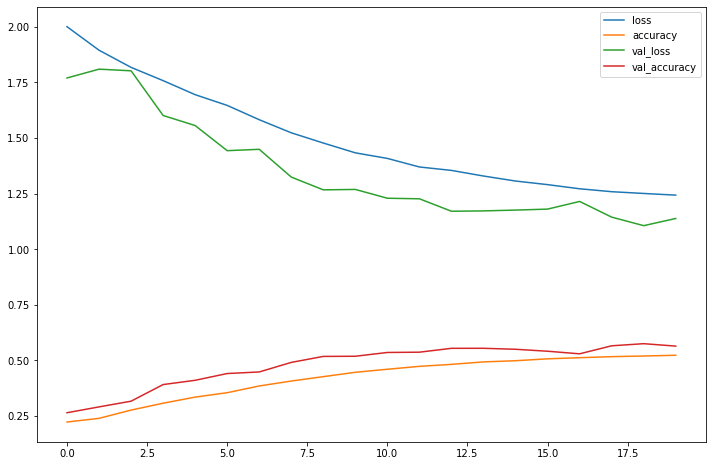

In [ ]:
pd.DataFrame(history.history).plot(figsize=(12, 8))

In [ ]:
model.evaluate(validation_generator)

221/221 [==============================] - 5s 22ms/step - loss: 1.1370 - accuracy: 0.5651


[1.1369820833206177, 0.5651004910469055]

In [ ]:
location = '/content/drive/MyDrive/Colab Notebooks/Face_expression_recognition_project/saved_models/model_6.h5'

model.save(location)

In [ ]:
num_train = 28709
num_val = 7178
batch_size = 64
num_epoch = 50

model_2 = Sequential()

model_2.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
model_2.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))

model_2.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))

model_2.add(Flatten())
model_2.add(Dense(1024, activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(7, activation='softmax'))


model_2.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0001, decay=1e-6),metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history_2 = model_2.fit_generator(
            train_generator,
            steps_per_epoch=num_train // batch_size,
            epochs=num_epoch,
            validation_data=validation_generator,
            validation_steps=num_val // batch_size)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


448/448 [==============================] - 21s 44ms/step - loss: 1.8332 - accuracy: 0.2371 - val_loss: 1.7713 - val_accuracy: 0.4171
Epoch 2/50
448/448 [==============================] - 19s 43ms/step - loss: 1.7905 - accuracy: 0.2631 - val_loss: 1.8324 - val_accuracy: 0.2321
Epoch 3/50
448/448 [==============================] - 19s 42ms/step - loss: 1.7555 - accuracy: 0.2762 - val_loss: 1.6715 - val_accuracy: 0.3831
Epoch 4/50
448/448 [==============================] - 19s 43ms/step - loss: 1.7030 - accuracy: 0.3083 - val_loss: 1.7097 - val_accuracy: 0.3301
Epoch 5/50
448/448 [==============================] - 19s 43ms/step - loss: 1.6702 - accuracy: 0.3301 - val_loss: 1.5363 - val_accuracy: 0.4085
Epoch 6/50
448/448 [==============================] - 20s 45ms/step - loss: 1.6335 - accuracy: 0.3533 - val_loss: 1.4871 - val_accuracy: 0.4138
Epoch 7/50
448/448 [==============================] - 19s 43ms/step - loss: 1.5902 - accuracy: 0.3747 - val_loss: 1.4264 - val_accuracy: 0.4573
Epo

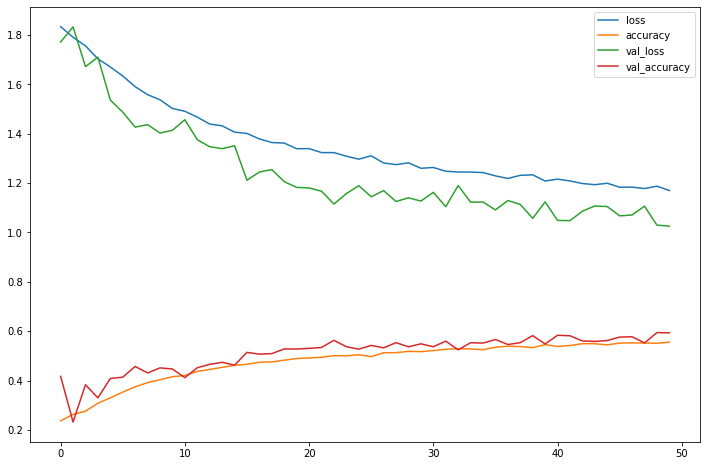

In [ ]:
pd.DataFrame(history_2.history).plot(figsize=(12, 8))

In [ ]:
location = '/content/drive/MyDrive/Colab Notebooks/Face_expression_recognition_project/saved_models/model_7.h5'

model_2.save(location)

# 3rd model

In [6]:
# number of images to feed into the NN for every batch
batch_size = 128

pic_size = 48

datagen_train = ImageDataGenerator()
datagen_validation = ImageDataGenerator()

train_generator = datagen_train.flow_from_directory(train_dir,
                                                    target_size=(pic_size,pic_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

validation_generator = datagen_validation.flow_from_directory(validation_dir,
                                                    target_size=(pic_size,pic_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [8]:
# number of possible label values
nb_classes = 7

# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(nb_classes, activation='softmax'))

opt = tf.keras.optimizers.Adam(lr=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [9]:
%%time

# number of epochs to train the NN
epochs = 50

from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit_generator(generator=train_generator,
                                steps_per_epoch=train_generator.n//train_generator.batch_size,
                                epochs=epochs,
                                validation_data = validation_generator,
                                validation_steps = validation_generator.n//validation_generator.batch_size,
                                callbacks=callbacks_list
                                )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  from ipykernel import kernelapp as app


Epoch 1/50
225/225 [==============================] - 37s 108ms/step - loss: 2.0517 - accuracy: 0.2309 - val_loss: 1.7310 - val_accuracy: 0.3119
Epoch 2/50
225/225 [==============================] - 24s 106ms/step - loss: 1.8346 - accuracy: 0.2959 - val_loss: 1.6593 - val_accuracy: 0.3581
Epoch 3/50
225/225 [==============================] - 23s 102ms/step - loss: 1.7349 - accuracy: 0.3395 - val_loss: 1.5815 - val_accuracy: 0.3882
Epoch 4/50
225/225 [==============================] - 23s 102ms/step - loss: 1.6606 - accuracy: 0.3656 - val_loss: 1.5587 - val_accuracy: 0.3986
Epoch 5/50
225/225 [==============================] - 23s 103ms/step - loss: 1.6013 - accuracy: 0.3873 - val_loss: 1.5218 - val_accuracy: 0.4162
Epoch 6/50
225/225 [==============================] - 23s 103ms/step - loss: 1.5428 - accuracy: 0.4081 - val_loss: 1.6067 - val_accuracy: 0.4045
Epoch 7/50
225/225 [==============================] - 23s 103ms/step - loss: 1.4941 - accuracy: 0.4298 - val_loss: 1.4567 - val_ac

In [11]:
model_accuracy = model.evaluate(validation_generator)

model_accuracy

56/56 [==============================] - 3s 52ms/step - loss: 1.0208 - accuracy: 0.6499


[1.0208085775375366, 0.6498726010322571]

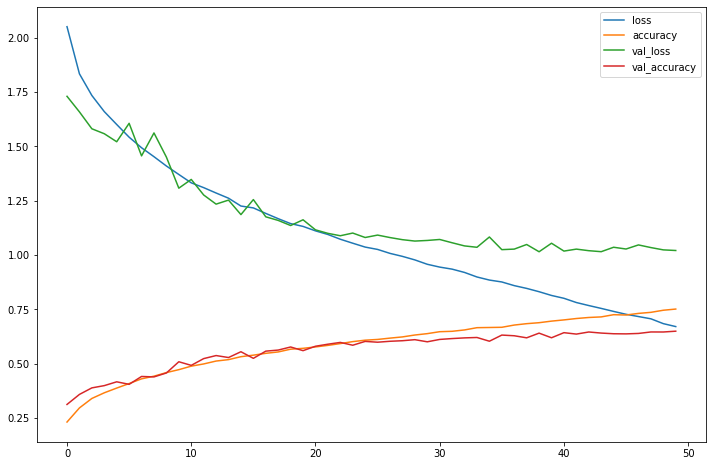

In [10]:
pd.DataFrame(history.history).plot(figsize=(12, 8))

In [12]:
location = '/content/drive/MyDrive/Colab Notebooks/Face_expression_recognition_project/saved_models/model_3.h5'

model.save(location)